## Historical Forest Mapping by DeepLabv3

Do inference and display the semantic segmentation results

__Step 1.__ Import necessary packages

If the source code is in Google drive, then mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**go into the source code directory (either Google drive or other locations)**

In [2]:
%cd /content/drive/MyDrive/IPEO/project/DeepLabv3/sources

/content/drive/MyDrive/IPEO/project/DeepLabv3/sources


Import all packages, including the local one

In [3]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# local import
import custom_model

__Step 2.__ Find the hardware

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

__Step 3.__ Define file paths needed in this notebook

In [5]:
# define the path to the weights file
weights_dir = '/content/drive/MyDrive/IPEO/deeplabv3_weights.pth'
# path to the test images
img_path = "../demo_image/image.tif"
# path to the test labels
label_path = "../demo_image/target.tif"

__Step 4.__ Initialize the model with trained weights, and set the model in evaluation mode

In [6]:
# import our trained model
model = custom_model.initialize_model(3, keep_feature_extract=True)
state_dict = torch.load(weights_dir, map_location=device)
model = model.to(device)
model.load_state_dict(state_dict)

# set the model in evaluation mode
model.eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 97.8MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

__Step 5.__ Input one image in the test set, do the transform required by the model

In [7]:
# load the image
image = Image.open(img_path)

# define the transforms
image_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# apply transforms
image_tr = image_transforms(image)

__Step 6.__ Do the inference, generate the prediction

In [8]:
# do the inference
image_tr = image_tr.to(device)
image_tr = image_tr.unsqueeze(0)

outputs = model(image_tr)["out"]

# select the prediction only in the first two classes
outputs = outputs[:, :2, :, :]
# get the prediction
_, preds = torch.max(outputs, 1)

__Step 7.__ Resize the prediction back to the original size, display the image, prediction and ground truth

In [9]:
# load the label
label = Image.open(label_path)

# resize the prediction to the label size
preds = transforms.Resize(size=(label.size[1], label.size[0]), interpolation=transforms.InterpolationMode.NEAREST)(preds)

# convert the prediction and label to numpy array
preds = preds.cpu().numpy()
preds = preds.squeeze(0)
label = np.array(label)

# change color of the prediction and label
colors = {
    0: [0,0,0],  # non-forest is black
    1: [0,255,0],  # forest is green
    2: [128,128,128],    # no-label is gray
    255: [128,128,128]
}
h, w = label.shape
pred_rgb = np.zeros((h, w, 3), dtype=np.uint8)
label_rgb = np.zeros((h, w, 3), dtype=np.uint8)

for index, rgb in colors.items():
  pred_rgb[preds == index, :] = rgb
  label_rgb[label == index, :] = rgb

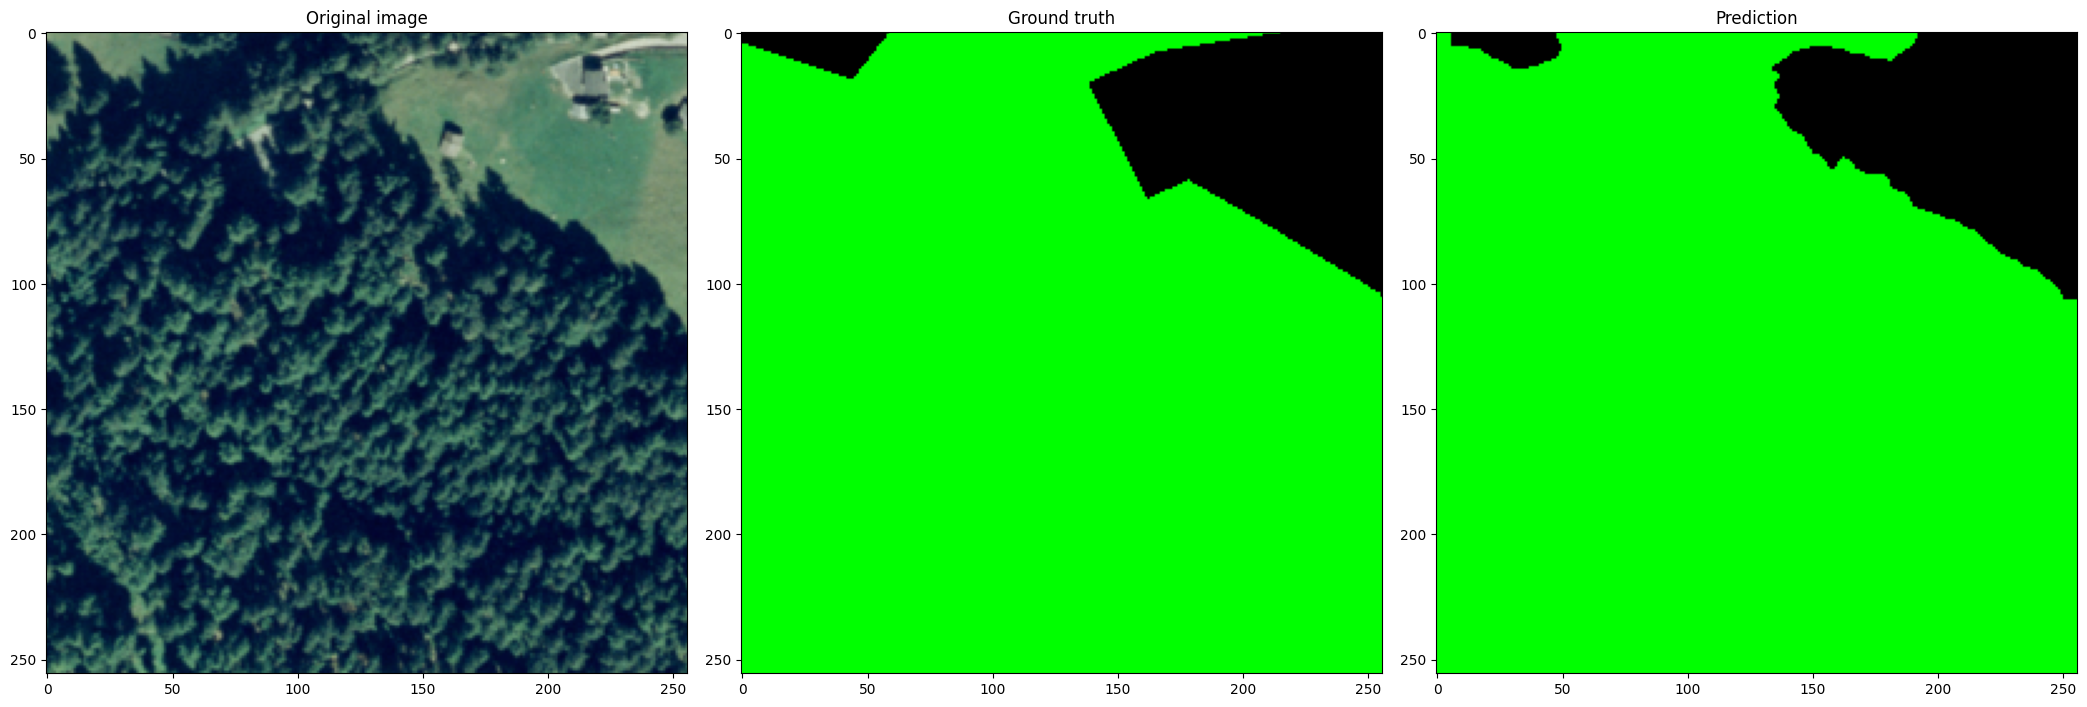

(None, None)

In [10]:
# display the original image, prediction and label
plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1), plt.imshow(image), plt.title("Original image")
plt.subplot(1, 3, 2), plt.imshow(label_rgb), plt.title("Ground truth")
plt.subplot(1, 3, 3), plt.imshow(pred_rgb), plt.title("Prediction")
plt.tight_layout(), plt.show()